# Segmentación de imágenes 2D con redes completamente convolucionales (conjunto Cityscapes)

La __segmentación__ nos permite dividir una imagen, 2D en este caso, en subimagenes identificables.

Algunos métodos clásicos de segmentación son la __umbralización__, el algoritmo __split & merge__, los algoritmos de __rellenado de regiones__, el algoritmo de __watershed__ o los __modelos deformables__.

Los principales métodos de segmentación clásicos están implementados en librerías de Python como OpenCV o Scikit-Image:

https://pypi.org/project/opencv-python/

https://pypi.org/project/scikit-image/

Que se pueden instalar desde los comandos

In [1]:
# !pip install opencv-python
# !pip install scikit-image

Para __validar__ la segmentación, tiene que haber una segmentación de referencia, lo que se denomina generalmente como un __ground truth__ (o '_etiquetado manual de imágenes_'). Este ground truth se tiene que obtener de forma manual, pintando la silueta de los objetos de interés con un color uniforme. Todo ello resulta un proceso muy tedioso. Este ground truth será comparado con la segmentación realizada por el método de visión artificial, por medio de una serie de métricas que evaluarán la precisión con la que el sistema segmenta.

Se puede plantear una red convolucional para __segmentar__ una imagen, obteniendo otra imagen con los __objetos de interés__ segmentados. 

Para ello se realiza una adaptación a la red convolucional propuesta por __LeCun__ donde las capas convolucionales acaban en una red densa o perceptrón que realiza la puntuación del objeto completo. Aquí se sustituye la red densa o __capa fully connected__ por un nuevo conjunto de capas convolucionales. De forma que se tienen dos bloques, primero un __Encoder__ seguido de un __Decoder__. 

<img src="images/RedFullyConvolutional.png" width="550px">

El __encoder__ reduce la dimensionalidad de la imagen de entrada hasta llegar a un __vector de características__. Por su parte, el decoder utiliza ese vector de características como entrada (que en la figura de abajo se denomina como latent representation) y aumenta poco a poco su dimensionalidad hasta llegar a la imagen de salida, que será la correspondiente a la __segmentación__.
 
<img src="images/RedFullyConvolutional_2.png" width="550px">

La representación del modelo __decoder - encoder__ tiene un aspecto de __U__ por lo que se denominan __redes en U__ o __U-net__.

Siempre está latente el problema de la escasez de datos etiquetados manualmente mencionado antes. Los modelos de aprendizaje profundo necesitan de una enorme cantidad de datos para ser entrenados, en general. 

En los últimos años, se han hecho muchos esfuerzos para solventar ese problema. Para ello, se pueden utilizar estrategias como el __data augmentation__, que básicamente pretende aumentar el tamaño de un conjunto de imágenes de manera artificial, es decir, sin necesidad de añadir ejemplos etiquetados nuevos.

El __data augmentation clásico__ utiliza __transformaciones triviales__ como rotaciones aleatorias, traslaciones o cambios de intensidad de los píxeles, pero cabe destacar que, en los últimos años, ha cobrado mucha importancia la generación de imagen sintética, con las redes generativas antagónicas (GAN) como una de la estrategias más utilizadas para tal fin (IArtificial.net; Martinez J.):

https://www.iartificial.net/redes-neuronales-generativas-adversarias-gans/



https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862

**En el presente cuaderno se realiza una implementación sencilla con PyTorch de una red U-Net, que es un métodos de segmentación de aprendizaje profundo propuesto por {cite:p}`ronneberger2015u` y {cite:p}`long2015fully`**. 

Ronneberger por ejemplo propone el modelo para realizar una segmentación de imagenes biomédicas, en concreto la segmentación de estructuras neuronales en pilas microscópicas electrónicas:

<img src="images/RedFullyConvolutional_3.png" width="400px">

Que se resuelve mediante la siguiente arquitectura:

<img src="images/RedFullyConvolutional_4.png" width="500px">

En este ejercicio para solventar el problema de contar con un conjunto de datos con anotaciones para el entrenamiento se utiliza un **simulador de imágenes**.

La segmentación tiene lugar en mapas, uno para cada una de las clases u objetos de interés. Ronneberger segmenta en 2 clases, pero en la simulación se utilizan 6 tipos de objetos (circunferencia, circulo sólido, triangulo y cuadrado sólido y cuadrado con trama), por lo que la dimensión de la salida de la red y de las variables objetivos o target con las anotaciones son 6 mapas de dimensión [192,192]. Puesto que se usan lotes de 25 imágenes, la dimensión de cada sálida será [25, 6, 192, 192]. Las entradas son en los tres canales (R,G,B) por lo que su dimensión es [25, 3, 192, 192]

La arquitectura que se utiliza para resolver el cuaderno está formada por __5 capas de bajada y 5 capas de subida, formando la red en U__. Las __2 primeras capas de bajada utilizan una red residual de 18 subcapas (ResNet18) ya pre-entrenada__ que está disponible en la librería __torchvision.models.resnet18__

## Importación de las librerías necesarias

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
from torchvision import datasets
from pathlib import Path
from torchvision import transforms
from torchvision import datasets 
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np

In [3]:
googleColaboratory = False
entrenamiento = False

In [7]:
if googleColaboratory:
    import google as goo
    goo.colab.drive.mount('/content/drive/')
    filename = "/content/drive/My Drive/Colab Notebooks/data/modeloUnet_cityscapes.pt" 
else:
    filename = "data/modeloUnet_cityscapes.pt"

## Dataset empleado

www.cityscapes-dataset.net

El conjunto de datos de __paisajes urbanos__ son datos a gran escala que contiene un conjunto diverso de secuencias de video estéreo grabadas en escenas callejeras de 50 ciudades diferentes, con anotaciones a nivel de píxeles de alta calidad de 5000 cuadros, además de un conjunto más grande de 20000 cuadros con anotaciones débiles.

Se han hecho unas pruebas básicas con un subconjunto de cityscapes que se encuentra en una carpeta de Google Drive:

https://drive.google.com/drive/folders/1KlA40ddni1FRZ0CZkCgtLyG5SBOKXEOi

En la anterior carpeta para train, están volcadas 3 ciudades (Bremen, Bouchon, Aachen) y para test Berlin. 

El dataset completo de cityscapes se corresponde con 50 ciudades alemanas donde aparecen anotados objetos de interés de acuerdo a la siguiente lista:

In [8]:
lst = [ [cls.id, cls.name, cls.category, cls.color] for cls in datasets.Cityscapes.classes]
dfClases = pd.DataFrame(lst, columns =['ID','Name', 'Category', 'color'])
nameClase = {cls.id:cls.name for cls in datasets.Cityscapes.classes}
numClases = len(nameClase) - 1 ## No consideramos el ID 0 como clase
dfClases

,ID,Name,Category,color
0,0,unlabeled,void,"(0, 0, 0)"
1,1,ego vehicle,void,"(0, 0, 0)"
2,2,rectification border,void,"(0, 0, 0)"
3,3,out of roi,void,"(0, 0, 0)"
4,4,static,void,"(0, 0, 0)"
5,5,dynamic,void,"(111, 74, 0)"
6,6,ground,void,"(81, 0, 81)"
7,7,road,flat,"(128, 64, 128)"
8,8,sidewalk,flat,"(244, 35, 232)"
9,9,parking,flat,"(250, 170, 160)"


In [9]:
pathCity = Path("/content/drive/MyDrive/Colab Notebooks/data/cityscapes") if googleColaboratory else Path("./data/cityscapes")
print(pathCity.absolute())

C:\Users\valer_z\ownCloud - VALERIANO MENDEZ FUENTES@drive.upm.es\AA\jupyterbook\bookIAA\data\cityscapes


In [10]:
imageSize=192
nameClase = {cls.id:cls.name for cls in datasets.Cityscapes.classes}
numClases = len(nameClase) - 1 ## No consideramos el ID 0 como clase
#usedClass = [24,25,26,27,33]

default_transforms = transforms.Compose([
                                transforms.Resize((128,256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.28689554, 0.32513303, 0.28389177], std=[0.18696375, 0.19017339, 0.18720214])
                              ])
default_transforms_target = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Lambda(lambda t: t.squeeze())
                              ])
def toLabel(image):
  image = image.resize((256,128))
  #numClases = len([cls for cls in datasets.Cityscapes.classes])-1
  ini_tensor = torch.from_numpy(np.array(image)).long().unsqueeze(0) 
  tSize = ini_tensor.size()
  fin_tensor = torch.zeros(numClases, tSize[1], tSize[2])
  #print('fin_tensor.shape=', fin_tensor.shape)
  for j in range(tSize[1]):
      for k in range(tSize[2]):
        it = ini_tensor[0][j][k]
        try:
          if it > -1 and it <= numClases:
            fin_tensor[it][j][k] = 1
        except Exception as e:
          #print(e, "it=", it)
          continue
  return fin_tensor

import torchvision.utils

def reverse_transform(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)

  return inp

En __cityscapes__ las anotaciones de la segmentación viene en un archivo imagen que en la función __toLabel__ se convierte en una matriz de enteros (__init_tensor__) que luego se vuelca en un mapa o tensor bidimensional por cada tipo de objeto. 

Así los enteros __5__ que aparece en posiciones __i,j__ de la matriz _init_tensor_, por poner un ejemplo, se vuelcan sobre __fin_tensor[4]__ con un valor a __1__. Por defecto cada mapa está a __0__ y se pone a __1__ los valores anotados.

In [11]:
if entrenamiento:
    traindataset = datasets.Cityscapes(root=pathCity, split='train', mode='fine', target_type='semantic', transform=default_transforms, target_transform=toLabel)
    trainloader = DataLoader(dataset=traindataset, batch_size=32, shuffle=True)


__Y el dataset de pruebas__

In [12]:
testdataset = datasets.Cityscapes(root=pathCity, split='val', mode='fine', target_type='semantic', transform=default_transforms, target_transform=toLabel)
testloader = DataLoader(dataset=testdataset, batch_size=3, shuffle=True)


Cada iteración del __Loader__ devuelve un tensor con la imagen a segmentar (en __inputs__) y un los mapas con las anotaciones de la segmentación (en __labels__).

Las dimensiones de los tensores de son:

- __inputs__: __(n, 3, h, b)__, siendo __n__ el nº de lotes (3), __h__ la altura (128) y __b__ el ancho de la imagen (256). En la segunda dimensión aparece el número de canales para el valor del color __(r,g,b)__.
- __labels__: __(n, 34, h, b)__, siendo __n__ el nº de lotes (3), __h__ la altura (128) y __b__ el ancho de la imagen (256). En la segunda dimensión aparece el número total de mapas, 34, uno por cada tipo de objeto.

Aquí se hace una impresión de la primera imagen del lote con __imshow__ usando el primer canal del color (r). Simplemente para ver la forma:

torch.Size([3, 34, 128, 256]) torch.Size([3, 3, 128, 256]) (128, 256)


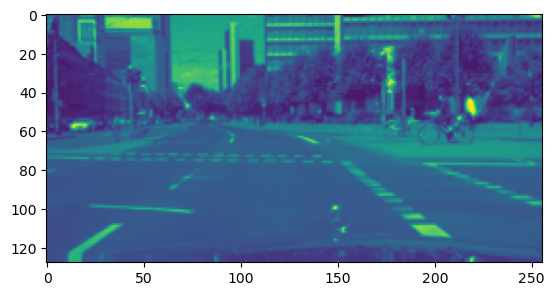

In [13]:
import matplotlib.pyplot as plt

inputs, labels = next(iter(testloader))
#plt.imshow(labels.cpu().numpy()[0])
plt.imshow(inputs.cpu().numpy()[0][0])
print(labels.shape, inputs.shape, inputs.cpu().numpy()[0][0].shape)

### Opciones de ayuda

Opciones que nos permiten realizar una impresión tanto de la imagen inicial (__inputs__), como una imagen única de las 34 etiquetas (__labels__), donde se da un color por etiqueta, haciendo una imagen única.

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    #print('ncol=', ncol, 'nrow=', nrow, "len=", len(img_array))

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
      if nrow == 1:
        plots[i % ncol]
        plots[i % ncol].imshow(img_array[i])
      else:
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

from functools import reduce
def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

import itertools
def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()

def masks_to_colorimg(masks):
    #colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])
    #colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132)])
    colors = np.asarray([(  0,  0,  0), (  0,  0,  0), (  0,  0,  0), (  0,  0,  0), (111, 74,   0), 
     ( 81, 0,  81) , (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), ( 70, 70,  70), (102, 102, 156),
     (190, 153, 153) , (180, 165, 180), (150, 100, 100), (150, 120,  90), (153, 153, 153), (153, 153, 153),
     (250, 170,  30), (220, 220,   0), (107, 142,  35), (152, 251, 152), ( 70, 130, 180), (220, 20,  60),
     (255, 0,   0) , (  0, 0, 142) , (  0, 0,  70) , (  0, 60, 100), 
     (  0, 0,  90), (  0, 0, 110), (  0, 80, 100), (  0, 0, 230), (119, 11,  32), (  0, 0, 142)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            #print(masks[:,y,x], len(masks[:,y,x]), len(colors))
            selected_colors = colors[masks[:,y,x] > 0.4]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

In [15]:
input, target = next(iter(testloader))
input_images = input.cpu().numpy()
target_masks = target.cpu().numpy()
print("input_images shape and range", input_images.shape, input_images.min(), input_images.max())
print("target_masks shape and range", target_masks.shape, target_masks.min(), target_masks.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in input]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

input_images shape and range (3, 3, 128, 256) -1.7096663 3.8253205
target_masks shape and range (3, 34, 128, 256) 0.0 1.0


## A la izquierda imagen de entrada (blanco y negro), A la derecha máscara objetivo (una clase por color) 

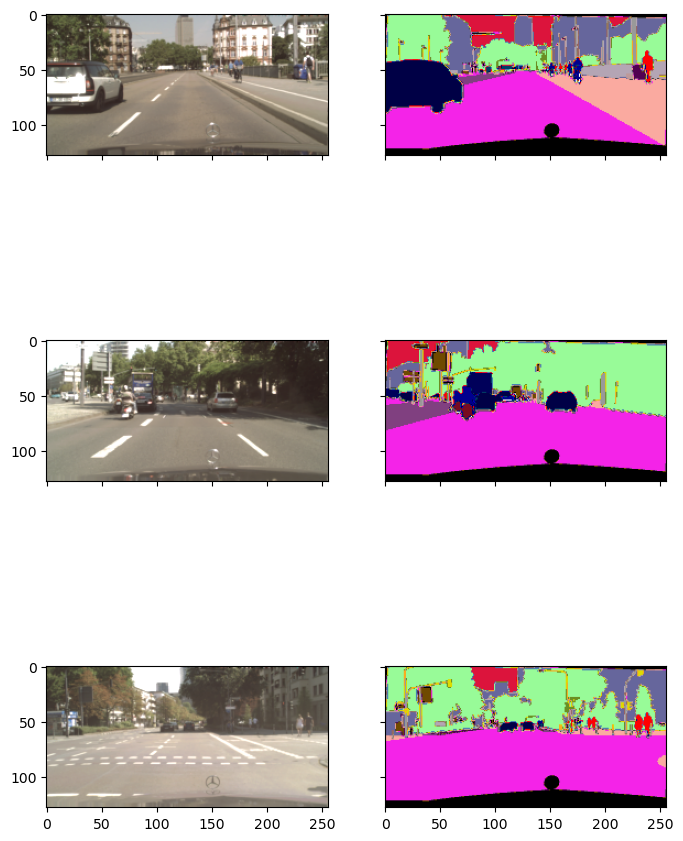

In [16]:
plot_side_by_side([input_images_rgb[0:3], target_masks_rgb[0:3]])

## Modelo U-net usando decoder y encoder

### Encoder

In [17]:
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)

### Decoder

In [18]:
class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)

### Utilidad para inicializar pesos en la clase principal

In [19]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

### Clase principal U-Net

In [20]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        return F.upsample(final, x.size()[2:], mode='bilinear')

## Modelo U-net

__5 capas de bajada (las 2 primeras basadas en ResNet18) y 5 de subida formando una red U__



In [21]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(weights=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

### Se crea un objeto Modelo

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if googleColaboratory else torch.device("cpu")
print("device=", device)
model = ResNetUNet(numClases)
#model = UNet(numClases)
model.to(device);

device= cpu


C:\Users\valer_z\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [24]:
#!pip install torch-summary

In [25]:
from torchsummary import summary
summary(model, input_size=(3, 192, 192))

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              230,144
|    |    └─BasicBlock: 3-4              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              919,040
|    |    └─BasicBlock: 3-6              1,180,672
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              3,673,088
|    |    └─BasicBlock: 3-8              4,720,640
|    └─AdaptiveAvgPool2d: 2-9            --
|    └─Linear: 2-10                      513,000
├─Sequential: 1-2                        --
|    └─Conv2d: 2-1

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              230,144
|    |    └─BasicBlock: 3-4              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              919,040
|    |    └─BasicBlock: 3-6              1,180,672
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              3,673,088
|    |    └─BasicBlock: 3-8              4,720,640
|    └─AdaptiveAvgPool2d: 2-9            --
|    └─Linear: 2-10                      513,000
├─Sequential: 1-2                        --
|    └─Conv2d: 2-1

### Método de optimización

In [26]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
# freeze backbone layers
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

### Función de pérdida

Para el cálculo de la pérdida se emplea el **índice de Sørensen-Dice** es un coeficiente de similitud de datos (DSC), que toma valores en el rango $[0,1]$. Que si vienen dados por dos conjuntos $X$ e $Y$ se puede expresar (siendo el módulo la cardinalidad):

$$ DSC = \frac{2|X \cap Y|}{|X|+|Y|} $$

Para evitar divisiones por cero es habitual añadir un coeficiente suavizador (smooth) en el numerador y denominador.

La **función de pérdida** se construye entre una media ponderada de
- La función **binary_cross_entropy_with_logit** que mide la entropía cruzada binaria entre el objetivo y los logits de entrada.
- Índice de Sørensen-Dice.

In [27]:
import torch
import torch.nn as nn

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [28]:
import torch.nn as nn
def calc_loss(pred, target, metrics, bce_weight=1.0):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    #bce = nn.CrossEntropyLoss(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

In [29]:
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

### Carga del modelo pre-entreando desde un fichero

In [30]:
device = torch.device('cpu')
if googleColaboratory:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
model = ResNetUNet(numClases)
#model = UNet(numClases)

In [31]:
print("Fichero a recuperar=", filename, 'device=', device)
try:
  model.load_state_dict(torch.load(filename, map_location=torch.device(device))) #recovery trained model
  model.to(device);
  print(model)
except Exception as e:
  print('No ha sido posible carga el modelo pre-entrenado')
  print(e)

Fichero a recuperar= data/modeloUnet_cityscapes.pt device= cpu
ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

## Entrenar el modelo

Es recomendable entrenar el modelo en un entorno Google donde se dispone de aceleración de cálculo basada en tarjetas gráficas __GPU__ o __TPU__.

Puesto que las cuentas Google gratuitas tiene ciertas restricciones (no dispone de procesamiento de segundo plano), hay que prevenir que se cierre la sesión por falta de actividad interactuando con Drive de vez en cuando.

Además conviene ejectuar la siguiente celda con 1 o 2 épocas, con sucesivas ejecuciones. Cómo se guarda el resultado en el fichero pt vamos incrementalmente mejorando los pesos del modelo.

In [32]:
from collections import defaultdict
num_epochs = 2
best_loss = 1e10

# Train the model
for epoch in range(num_epochs):
    if not entrenamiento:
      print("No habilitada la opción de entrenamiento")
      break
    correct = 0
    total = 0
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    metrics = defaultdict(float)
    epoch_samples = 0
    model.train()
    NBatch = len(trainloader)
    for i, data in enumerate(trainloader):
        inputs, labels = data
        assert inputs.size()[2:] == labels.size()[2:]
        N = inputs.size(0)
        #inputs = Variable(inputs).to(device)
        #labels = Variable(labels).to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        assert outputs.size()[2:] == labels.size()[2:]
        assert outputs.size()[1] == numClases

        loss = calc_loss(outputs, labels, metrics)
        loss.backward()
        optimizer.step()

        epoch_samples += inputs.size(0)
        print("Batch=" + str(i) + "/" + str(NBatch))

    print_metrics(metrics, epoch_samples, 'train')
    epoch_loss = metrics['loss'] / epoch_samples

    if epoch_loss < best_loss:
        print(f"Salvando el mejor modelo en {filename}")
        best_loss = epoch_loss
        torch.save(model.state_dict(), filename)

            
print ('Final de Entrenamiento')

No habilitada la opción de entrenamiento
Final de Entrenamiento


## Se predicen nuevas imagenes usando el modelo entrenado

In [33]:
input, target = next(iter(testloader))
input_images = input.cpu().numpy()
target_masks = target.cpu().numpy()
print("input_images shape and range", input_images.shape, input_images.min(), input_images.max())
print("target_masks shape and range", target_masks.shape, target_masks.min(), target_masks.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in input]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

model.eval()   # Set model to the evaluation mode
inputs = inputs.to(device)
labels = labels.to(device)
# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
pred_rgb = [masks_to_colorimg(x) for x in pred]




input_images shape and range (3, 3, 128, 256) -1.7096663 3.8253205
target_masks shape and range (3, 34, 128, 256) 0.0 1.0


Se puede observar en los resultados, que el __entrenamiento es limitado__, fundamentalmente por haber usado sólo 3 ciudades en lugar de la base de datos completa, como por el número de épocas.

Aún así se aprecia un resutado (3ª columna) que es un bosquejo de la segmentación real que aparece en la 2ª columna. 

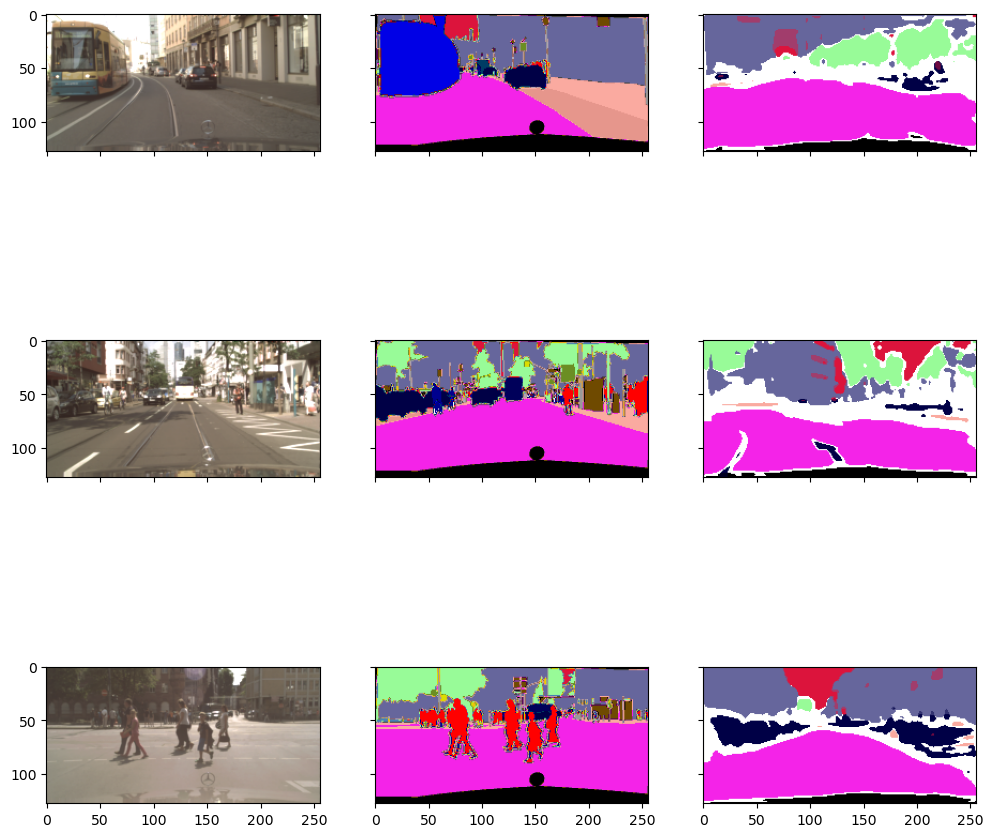

In [34]:
plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])